# Getting dataset

Due to work being done in colab I had to mount my gdrive, dataset is uploaded to gdrive as zip and begin extracted before working on it. Dataset source is Kaggle 10.34740/kaggle/dsv/2645886 https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/brain-mri-dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [3]:
import os
import numpy as np
import pandas as pd

train_path = './dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path) #store list of disease types
for directory in directories:
    f_path = os.path.join(train_path, directory) #join filepath with tumor name to get full path
    filelists = os.listdir(f_path) #get all files in list in current f_path
    filepaths.extend([os.path.join(f_path, file) for file in filelists]) #in current f_path add all files in filelist of it
    labels.extend([directory] * len(filelists)) #add label to current directory, number of labels equal to len(filelists)

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [4]:
train_frame

,filepaths,label
0,./dataset/Training/meningioma/Tr-me_0712.jpg,meningioma
1,./dataset/Training/meningioma/Tr-me_1169.jpg,meningioma
2,./dataset/Training/meningioma/Tr-me_0163.jpg,meningioma
3,./dataset/Training/meningioma/Tr-me_0630.jpg,meningioma
4,./dataset/Training/meningioma/Tr-me_0115.jpg,meningioma
...,...,...
5707,./dataset/Training/notumor/Tr-no_0827.jpg,notumor
5708,./dataset/Training/notumor/Tr-no_0529.jpg,notumor
5709,./dataset/Training/notumor/Tr-no_1582.jpg,notumor
5710,./dataset/Training/notumor/Tr-no_1054.jpg,notumor


In [5]:
test_path = './dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path) #store list of disease types
for directory in directories:
    f_path = os.path.join(test_path, directory) #join filepath with tumor name to get full path
    filelists = os.listdir(f_path) #get all files in list in current f_path
    filepaths.extend([os.path.join(f_path, file) for file in filelists]) #in current f_path add all files in filelist of it
    labels.extend([directory] * len(filelists)) #add label to current directory, number of labels equal to len(filelists)

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})


In [6]:
test_frame

,filepaths,label
0,./dataset/Testing/meningioma/Te-me_0244.jpg,meningioma
1,./dataset/Testing/meningioma/Te-me_0022.jpg,meningioma
2,./dataset/Testing/meningioma/Te-me_0106.jpg,meningioma
3,./dataset/Testing/meningioma/Te-me_0163.jpg,meningioma
4,./dataset/Testing/meningioma/Te-me_0235.jpg,meningioma
...,...,...
1306,./dataset/Testing/notumor/Te-no_0215.jpg,notumor
1307,./dataset/Testing/notumor/Te-no_0399.jpg,notumor
1308,./dataset/Testing/notumor/Te-no_0379.jpg,notumor
1309,./dataset/Testing/notumor/Te-no_0230.jpg,notumor


## Split Data into Valid and Test dataset
   Training Dataset: This is the portion of your data that you use to train your machine learning model. The model learns from this data by adjusting its internal parameters (weights) based on the patterns and information present in the training data. The goal is to help the model generalize from this data, so it can make accurate predictions on new, unseen data.

   Validation Dataset: The validation dataset is used during the training process to tune hyperparameters and assess the model's performance. The validation set is not used to update the model's weights, but it helps in monitoring and fine-tuning the model. This is crucial for preventing overfitting, as you can make decisions about the model's architecture or hyperparameters based on how well it performs on the validation data.

   Test Dataset: The test dataset is a separate, unseen dataset that the model has never encountered during training or validation. Its primary purpose is to evaluate the model's performance after it has been trained and tuned. By using a test set that the model has never seen, you can get an accurate measure of how well the model generalizes to new, real-world data.

In [7]:
from sklearn.model_selection import train_test_split
# Split Test directory into test and validation sets
valid, test = train_test_split(test_frame, train_size = 0.5 , shuffle = True , random_state = 42)
print(valid.shape)
print(test.shape)

(655, 2)
(656, 2)


## Image Data Generator Augmenting Training Data
It prevents overfitting by providing the model with variations of the data by applying realistic transformations, effectively making the training set more diverse. The validation set will help with checking if model is overfitting (if train accuracy is high but validation accuracy is low we have classic overfitting problem)

In [8]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [9]:
from keras.preprocessing.image import ImageDataGenerator
img_size = (300, 300) # Recommended for EffNetb3
batch_size = 16
# Augument training set to reduce overfitting and rescale images to be in [0, 1] range
# Important note efficientnet in keras implementation has normalization as part of the model so I've skipped rescale = 1./255 in datagen
# Check header 'Keras implementation of EfficientNet' https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
tr_gen = ImageDataGenerator(rotation_range = 5,
                            width_shift_range = 0.05,
                            height_shift_range = 0.05,
                            horizontal_flip=True,
                            )

ts_gen = ImageDataGenerator() # Test/Val sets shouldn't be augumented

train_gen = tr_gen.flow_from_dataframe(train_frame , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= False, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = False , batch_size = batch_size)
# Quick sanity check if everything is as expected
x_train, y_train = next(train_gen)
print(f"Train data shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}\n")

x_val, y_val = next(valid_gen)
print(f"Validation data shape: {x_val.shape}")
print(f"Validation labels shape: {y_val.shape}\n")

x_test, y_test = next(test_gen)
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Train data shape: (16, 300, 300, 3)
Train labels shape: (16, 4)

Validation data shape: (16, 300, 300, 3)
Validation labels shape: (16, 4)

Test data shape: (16, 300, 300, 3)
Test labels shape: (16, 4)


Everything seems correct our first argument 16 is batch size then we have image size 300, 300 and 3 color channels (RGB). We got 16 labels in batch which matches batch size and each vector is 4 dimensional due to 4 classes.

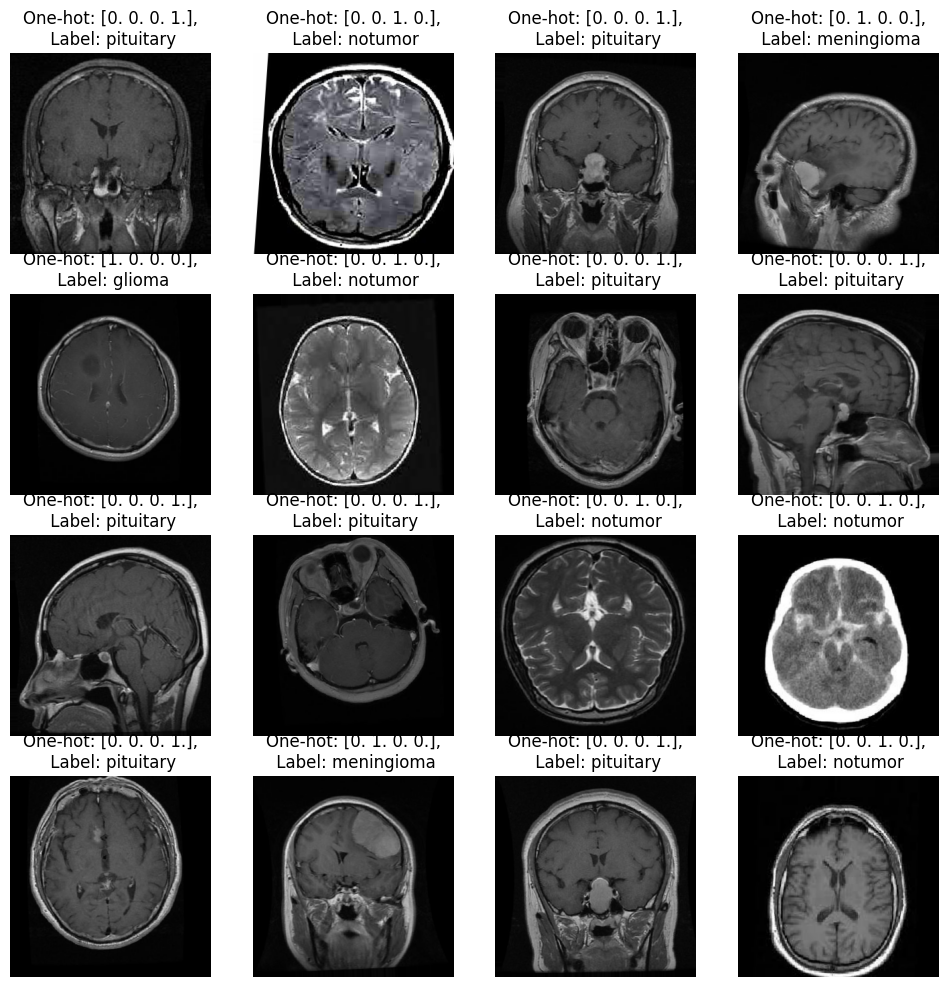

In [10]:
import matplotlib.pyplot as plt

images, labels = train_gen.next()
# Convert one-hot encoded labels to class names
label_names = list(train_gen.class_indices.keys())
# Get at which index in each row we have value 1
integer_labels = np.argmax(labels, axis=1)

plt.figure(figsize=(12, 12))
for i in range(len(images)):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255)
    plt.title(f'One-hot: {labels[i]},\n Label: {label_names[integer_labels[i]]}')
    plt.axis('off')
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Activation , Dense , Dropout , BatchNormalization
from keras.optimizers import Adam, Adamax
from keras import regularizers
img_shape = (300, 300, 3)


base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l = 0.02), activation = 'relu'),
    Dropout(rate = 0.4 , seed = 42),
    Dense(4 , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [12]:
history = model.fit(x = train_gen, validation_data = valid_gen, epochs = 8, shuffle = False, verbose = 1)

Epoch 1/8
357/357 [==============================] - 264s 573ms/step - loss: 6.1495 - accuracy: 0.8813 - val_loss: 3.7504 - val_accuracy: 0.9679
Epoch 2/8
357/357 [==============================] - 198s 555ms/step - loss: 2.5689 - accuracy: 0.9603 - val_loss: 1.6206 - val_accuracy: 0.9588
Epoch 3/8
357/357 [==============================] - 199s 558ms/step - loss: 1.0806 - accuracy: 0.9699 - val_loss: 0.6878 - val_accuracy: 0.9679
Epoch 4/8
357/357 [==============================] - 199s 555ms/step - loss: 0.4775 - accuracy: 0.9751 - val_loss: 0.2986 - val_accuracy: 0.9863
Epoch 5/8
357/357 [==============================] - 197s 550ms/step - loss: 0.2253 - accuracy: 0.9844 - val_loss: 0.1291 - val_accuracy: 0.9954
Epoch 6/8
357/357 [==============================] - 196s 549ms/step - loss: 0.1424 - accuracy: 0.9835 - val_loss: 0.0718 - val_accuracy: 0.9985
Epoch 7/8
357/357 [==============================] - 201s 564ms/step - loss: 0.0956 - accuracy: 0.9891 - val_loss: 0.0681 - val_ac

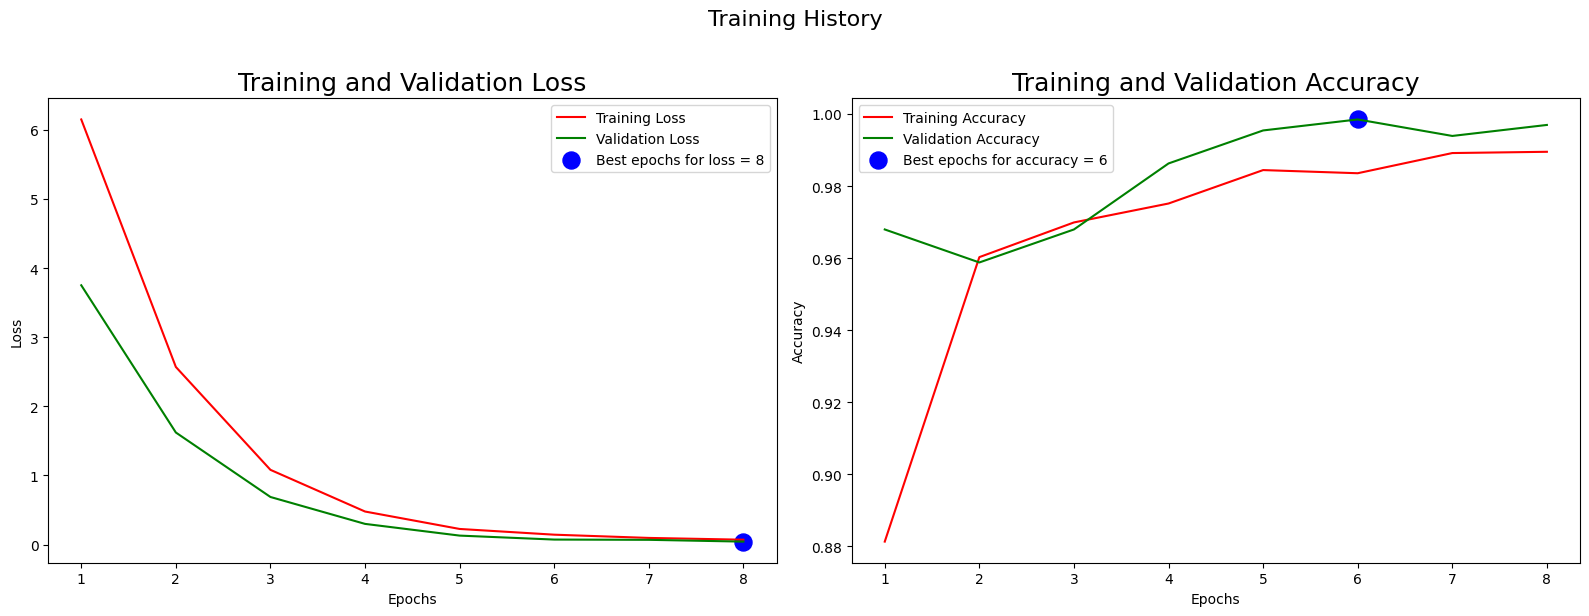

In [13]:
from sklearn.metrics import confusion_matrix , classification_report

train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epochs for loss = {str(index_loss + 1)}'
acc_label = f'Best epochs for accuracy = {str(index_acc + 1)}'

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

# Loss
axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].plot(Epochs, val_loss, 'g', label='Validation Loss')
axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
axes[0].set_title('Training and Validation Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].plot(Epochs, val_acc, 'g', label='Validation Accuracy')
axes[1].scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
axes[1].set_title('Training and Validation Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model on the training, validation, and test sets
sets_to_evaluate = [train_gen, valid_gen, test_gen]
set_names = ["Training", "Validation", "Test"]

for set_name, data_gen in zip(set_names, sets_to_evaluate):
    score = model.evaluate(data_gen, steps=32, verbose=1)
    loss, accuracy = score

    print(f"{set_name} Loss: {loss}")
    print(f"{set_name} Accuracy: {accuracy}")
    print('-' * 30)

32/32 [==============================] - 12s 372ms/step - loss: 0.0341 - accuracy: 1.0000
Training Loss: 0.034063179045915604
Training Accuracy: 1.0
------------------------------
32/32 [==============================] - 4s 110ms/step - loss: 0.0358 - accuracy: 1.0000
Validation Loss: 0.035841893404722214
Validation Accuracy: 1.0
------------------------------
32/32 [==============================] - 4s 110ms/step - loss: 0.0693 - accuracy: 0.9902
Test Loss: 0.0693259909749031
Test Accuracy: 0.990234375
------------------------------


41/41 [==============================] - 7s 154ms/step


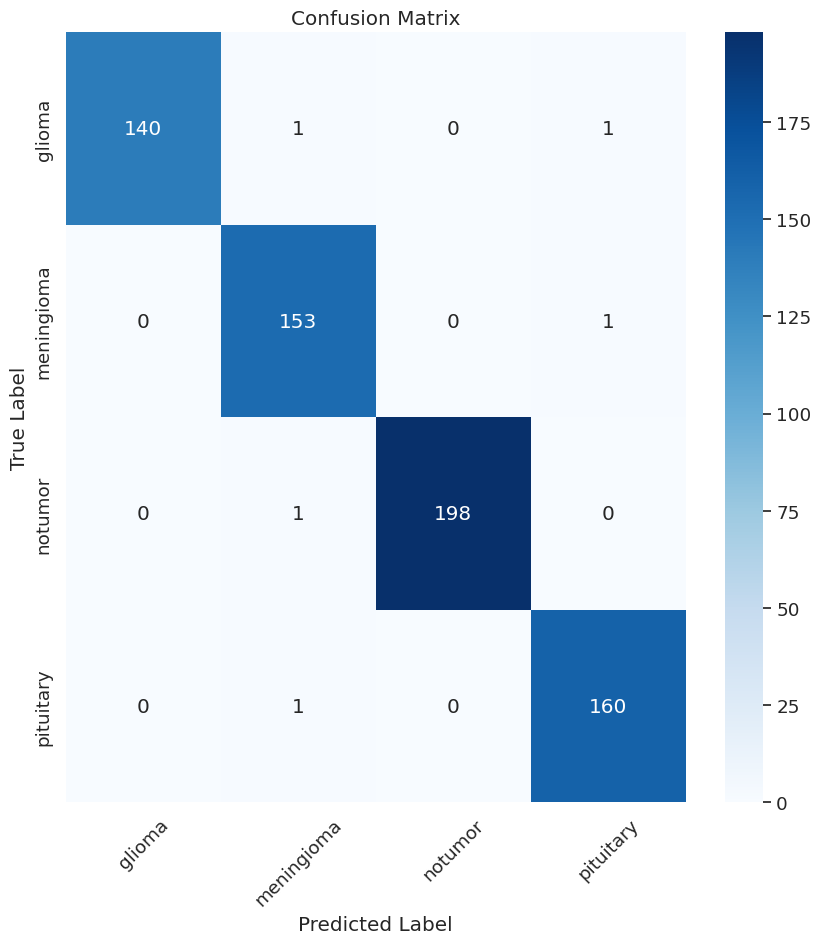

In [17]:
import seaborn as sns

preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes))

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       142
  meningioma       0.98      0.99      0.99       154
     notumor       1.00      0.99      1.00       199
   pituitary       0.99      0.99      0.99       161

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656

